<h1 style="color:orange">This Notebook was done in colaborate between Shibab Ahsan and Sebastian Rix</h1>

<h4>
<ol>
    <li>Let us see some statistical models and how they can be explained</li>
    <li>Your turn:</li>
        <ol>
            <li>Train at least two basic models on the energy dataset from TSA_Example notebook. You may choose to use only the last 5 years of the dataset to reduce data size</li>
            <li>Explain the patterns the model has learned via various plotting capabilities</li>
        </ol>
</ol>
<i>The hand in exercise for this topic is explained in slide 25 in the powerpoint
‘Explainability.pptx’. You need to do all the tasks within bullet 2 of this slide. Regarding
the second bullet, you should do at least 3 local plots per model, i.e. explain 3
rows/predictions from your test data and then have one global plot using SHAP.
Regarding bullet three, you should again explain 3 rows/predictions using LIME. Global
plot with LIME is not required.</i>
</h3>

<hr>
<h3>Two basic models from TSA_example</h3>

In [1]:
import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import shap
from lime.lime_tabular import LimeTabularExplainer

In [2]:
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")
df = pd.read_csv(path+"/PJME_hourly.csv")
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df = df.sort_index()



In [3]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

def create_features(df):
 
    df = df.copy()

    # Basic time-based features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    # Lag features
    df['lag_1d'] = df['PJME_MW'].shift(1)   # 1 day lag
    df['lag_1w'] = df['PJME_MW'].shift(7)   # 1 week lag
    df['lag_1m'] = df['PJME_MW'].shift(30)  # 1 month lag (approx. 30 days)
    df['lag_1y'] = df['PJME_MW'].shift(365) # 1 year lag

    # Rolling statistics features
    df['rolling_mean_3d'] = df['PJME_MW'].rolling(window=3).mean()  # Last 3 days rolling mean
    df['rolling_mean_30d'] = df['PJME_MW'].rolling(window=30).mean()  # Last month rolling mean
    df['rolling_mean_same_month_last_year'] = df['PJME_MW'].shift(365).rolling(window=30).mean()  # Same month previous year rolling mean
    df['rolling_mean_same_week_last_year'] = df['PJME_MW'].shift(365).rolling(window=7).mean()  # Same week previous year rolling mean

    return df

df = create_features(df)

train = create_features(train)
test = create_features(test)

train = train.dropna()
test = test.dropna()

FEATURES_LR = [
    'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
    ]
TARGET = 'PJME_MW'


FEATURES_XGB = [
    'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
    'lag_1d', 'lag_1w', 'lag_1m', 'lag_1y',
    'rolling_mean_3d', 'rolling_mean_30d', 'rolling_mean_same_month_last_year', 'rolling_mean_same_week_last_year'
]


# Linear Regression Data
X_train_lr = train[FEATURES_LR]
y_train_lr = train[TARGET]

X_test_lr = test[FEATURES_LR]
y_test_lr = test[TARGET]

# XGBoost Data
X_train_xgb = train[FEATURES_XGB]
y_train_xgb = train[TARGET]

X_test_xgb = test[FEATURES_XGB]
y_test_xgb = test[TARGET]


# Linear Regression

In [4]:
# Initialize the Linear Regression model
lr = LinearRegression()

# Train the model
lr.fit(X_train_lr, y_train_lr)

# Make predictions
y_pred_lr = lr.predict(X_test_lr)

# XGBoost

In [5]:
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb)
dtest = xgb.DMatrix(X_test_xgb, label=y_test_xgb)

# Set parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # Objective function for regression
    'eval_metric': 'rmse',  # Evaluation metric
    'max_depth': 3,  # Depth of the trees
    'learning_rate': 0.01,  # Learning rate
    'colsample_bytree': 0.8,  # Subsample of features
    'subsample': 0.8  # Subsample ratio
}

# Watchlist for monitoring performance on train and test sets
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Number of boosting rounds and early stopping
num_round = 1000  # Number of boosting rounds
early_stopping_rounds = 50  # Early stopping

# Train the model
reg = xgb.train(params, dtrain, num_round, watchlist, early_stopping_rounds=early_stopping_rounds,verbose_eval=100)


y_pred_xgb = reg.predict(dtest)

[0]	train-rmse:6399.59383	eval-rmse:6469.64026
[100]	train-rmse:2751.00590	eval-rmse:2770.87802


c:\Users\sebas\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[200]	train-rmse:1497.61143	eval-rmse:1498.74126
[300]	train-rmse:1056.26081	eval-rmse:1044.46570
[400]	train-rmse:867.07057	eval-rmse:861.59929
[500]	train-rmse:779.55504	eval-rmse:779.35260
[600]	train-rmse:726.49148	eval-rmse:731.41253
[700]	train-rmse:684.64061	eval-rmse:692.62863
[800]	train-rmse:653.45319	eval-rmse:664.24608
[900]	train-rmse:627.48734	eval-rmse:641.79736
[999]	train-rmse:601.67928	eval-rmse:619.35217


# Evaluation

In [6]:
#Evaluate Linear Regression
rmse_lr = np.sqrt(mean_squared_error(y_test_lr, y_pred_lr))
mae_lr = mean_absolute_error(y_test_lr, y_pred_lr)


#Evaluate XGBoost
rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test_xgb, y_pred_xgb)


print(f"Linear Regression - RMSE: {rmse_lr}")
print(f"Linear Regression - MAE: {mae_lr}")
print(f"XGBoost - RMSE: {rmse_xgb}")
print(f"XGBoost - MAE: {mae_xgb}")

Linear Regression - RMSE: 5675.009649771431
Linear Regression - MAE: 4589.252308326658
XGBoost - RMSE: 619.3521732551579
XGBoost - MAE: 480.2470851594207


<hr>
<h2>
Explain the patterns the model has learned via various plotting capabilities.  least 3 local plots per model, i.e. explain 3
rows/predictions from your test data and then have one global plot using SHAP.
Regarding bullet three, you should again explain 3 rows/predictions using LIME. Global
plot with LIME is not required.
</h2>

In [7]:
# To make 3 LOCAL row predictions we need to find 3 entries in test set. We take first , middle and last.
row_ids_lr  = [0, len(X_test_lr)//2,  len(X_test_lr)-1]
row_ids_xgb = [0, len(X_test_xgb)//2, len(X_test_xgb)-1]

print("LR rows:",  row_ids_lr,  [X_test_lr.index[i]  for i in row_ids_lr])
print("XGB rows:", row_ids_xgb, [X_test_xgb.index[i] for i in row_ids_xgb])

LR rows: [0, 15523, 31045] [Timestamp('2015-01-17 10:00:00'), Timestamp('2016-10-25 06:00:00'), Timestamp('2018-08-03 00:00:00')]
XGB rows: [0, 15523, 31045] [Timestamp('2015-01-17 10:00:00'), Timestamp('2016-10-25 06:00:00'), Timestamp('2018-08-03 00:00:00')]


<h3>Setup for SHAP and LIME</h3>

In [8]:
shap_explainer = shap.Explainer(reg)
shap_values = shap_explainer(X_test_xgb)

lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train_xgb),
    feature_names=FEATURES_XGB,
    mode='regression',
    discretize_continuous=True
)

<h3>Linear Regression GLOBAL feature importance via corelation (cefficients)</h3>

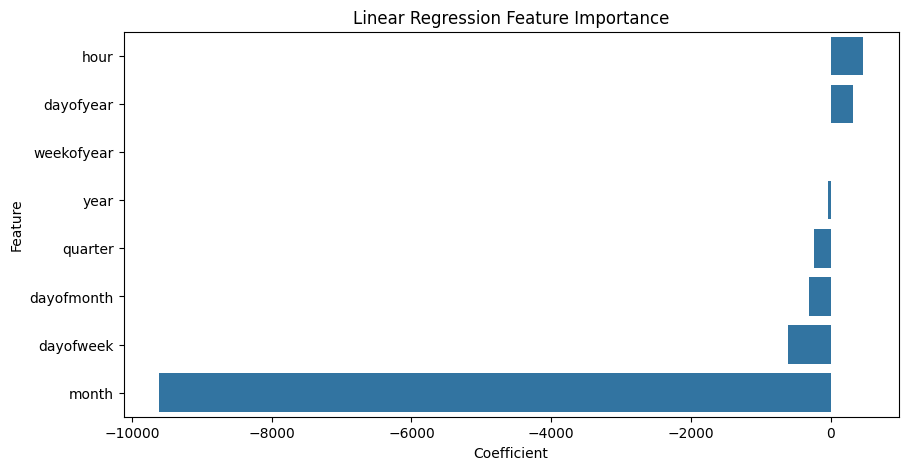

In [9]:
# Coefficients for feature importance for Linear Regression
feature_importance = pd.DataFrame({"Feature": FEATURES_LR, "Coefficient": lr.coef_})
feature_importance = feature_importance.sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x="Coefficient", y="Feature", data=feature_importance)
plt.title("Linear Regression Feature Importance")
plt.show()


<h3>Linear Regression 3 LOCAL plots. First-middle-last row</h3>

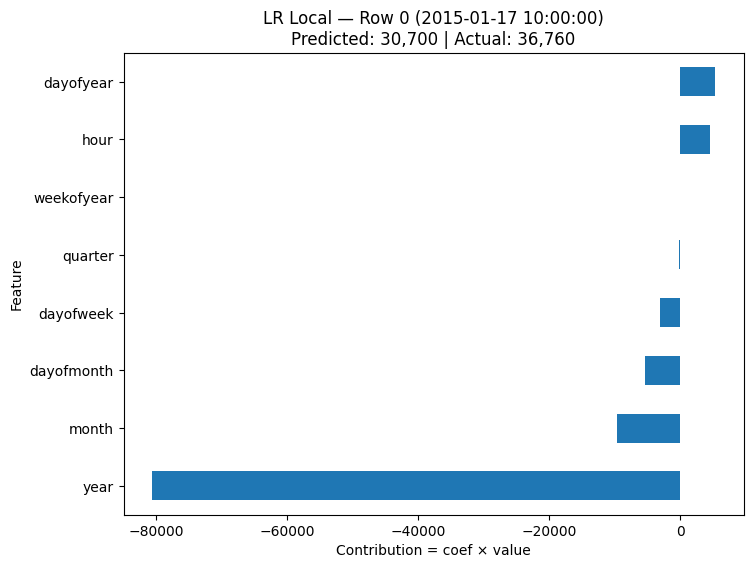

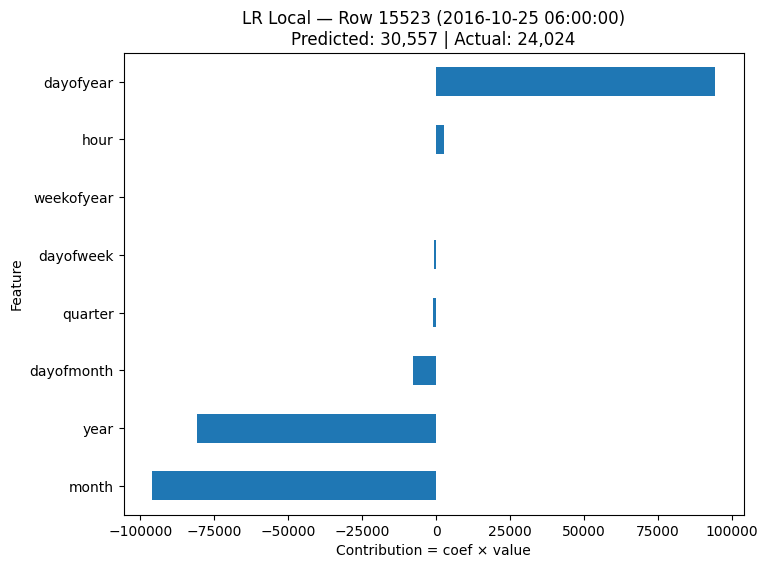

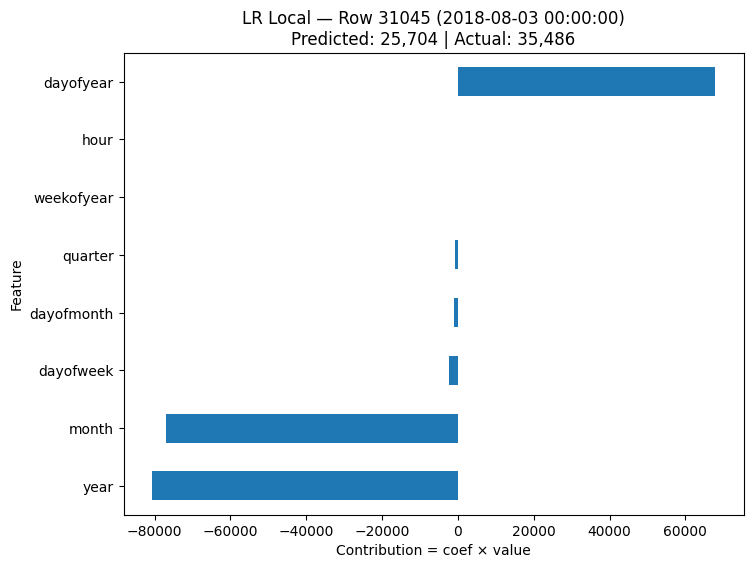

In [10]:
for i in row_ids_lr:
    x_row = X_test_lr.iloc[i]
    y_true = y_test_lr.iloc[i]
    y_pred = lr.predict(X_test_lr.iloc[[i]])[0]

    contribution = pd.Series(lr.coef_, index=FEATURES_LR) * x_row[FEATURES_LR]
    contribution.sort_values().plot(kind="barh", figsize=(8,6))
    plt.title(f"LR Local — Row {i} ({X_test_lr.index[i]})\nPredicted: {y_pred:,.0f} | Actual: {y_true:,.0f}")
    plt.xlabel("Contribution = coef × value")
    plt.ylabel("Feature")
    plt.show()

<h4> XGBoost GLOBAL / SHAP summary</h4>

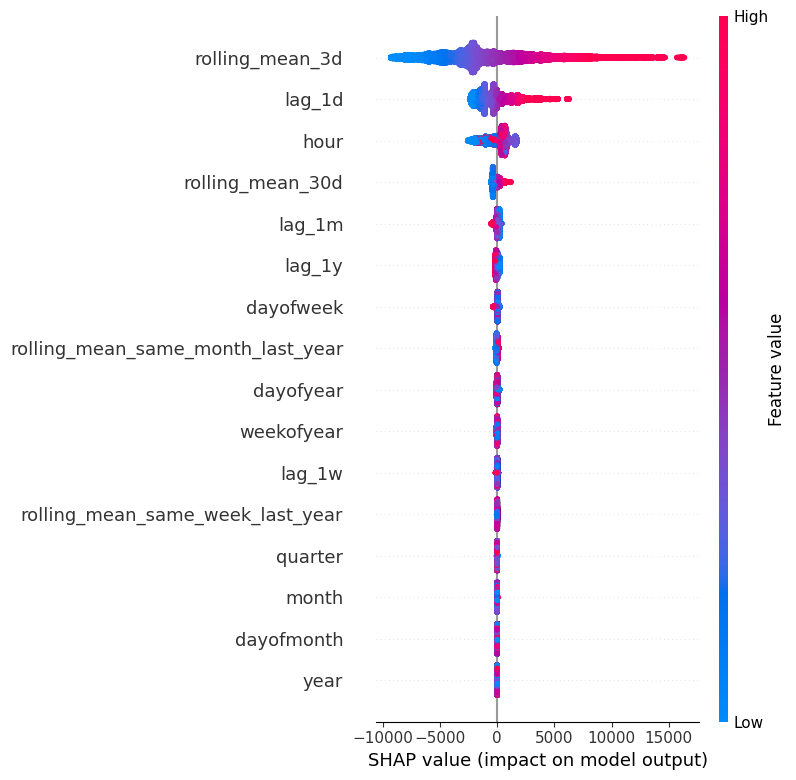

In [11]:
shap.summary_plot(shap_values, X_test_xgb, feature_names=FEATURES_XGB, show=True)

<h3>XGBoost 3 LOCAL plots. First-middle-last row / SHAP</h3>

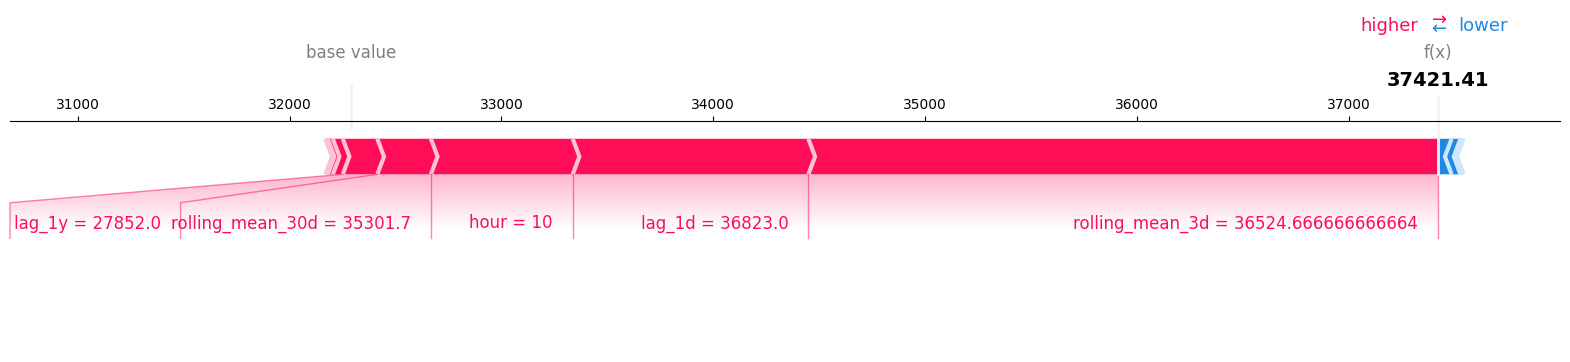

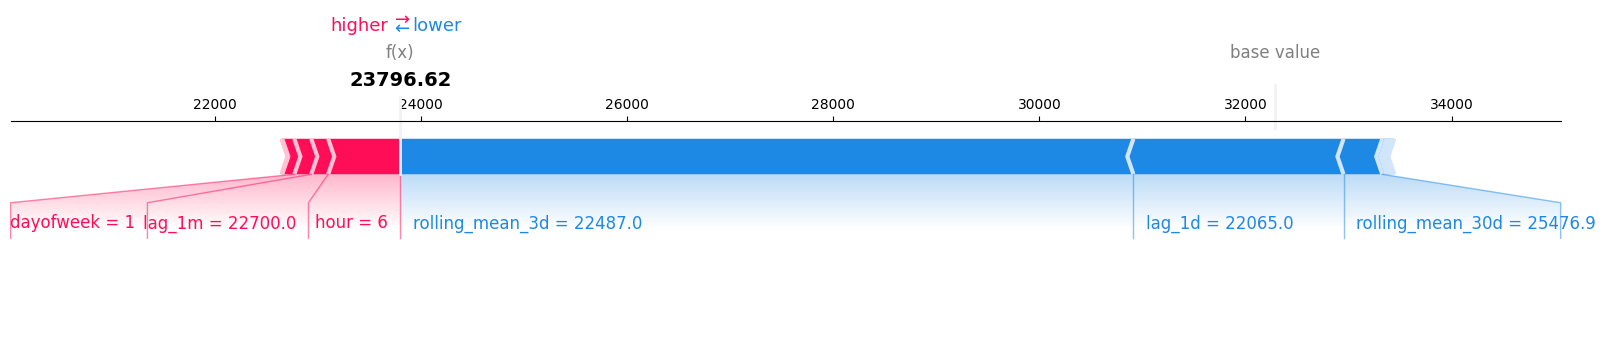

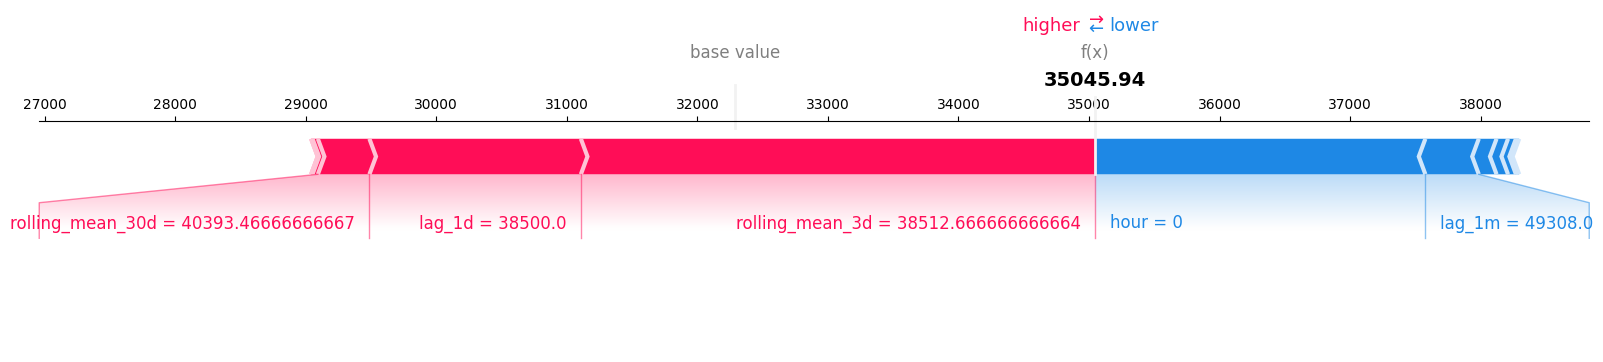

In [12]:
for i in row_ids_xgb:
    shap.force_plot(shap_values[i], matplotlib=True, show=True)


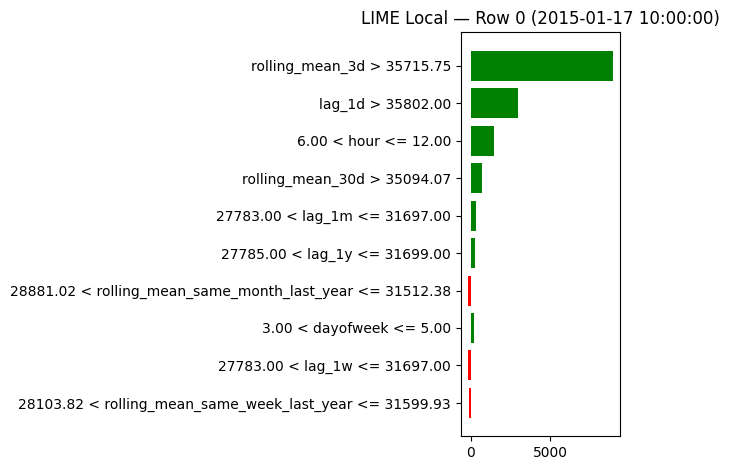

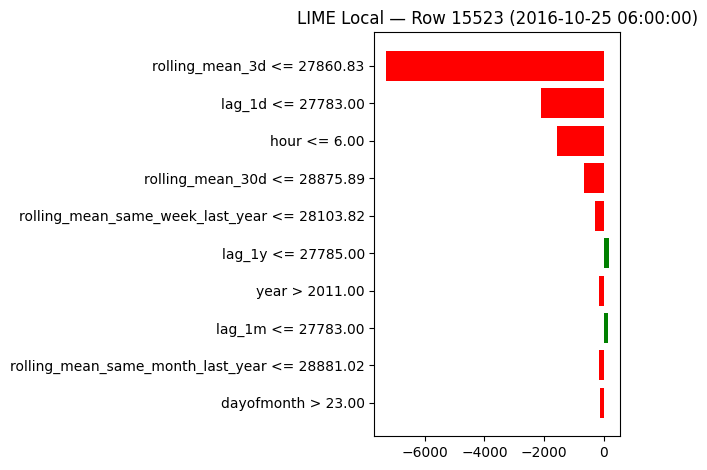

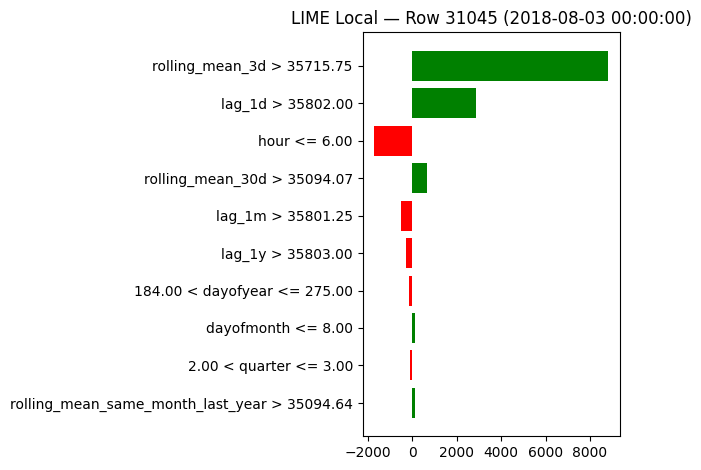

In [14]:
for i in row_ids_xgb:
    exp = lime_explainer.explain_instance(
        data_row=X_test_xgb.iloc[i].values,
        predict_fn=lambda X: reg.predict(xgb.DMatrix(pd.DataFrame(X, columns=FEATURES_XGB))),
        num_features=10
    )

    fig = exp.as_pyplot_figure()
    plt.title(f"LIME Local — Row {i} ({X_test_xgb.index[i]})")
    plt.tight_layout()
    plt.show()